In [69]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pickle
from tqdm import tqdm
import rdflib
from rdflib import Graph
from rdflib.namespace import BRICK
import warnings
from scipy import stats

In [38]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
filename_ttl='datasets/bts_site_b_train/Site_B.ttl'

g = Graph().parse(filename_ttl)

In [40]:
# Define the SPARQL query to retrieve Water Meter sensors

query_water = """
SELECT ?meter ?sensor ?stream_id
WHERE {
    ?sensor rdf:type brick:Usage_Sensor .
    ?meter rdf:type brick:Building_Water_Meter .
    ?sensor brick:isPointOf ?meter .
    ?sensor senaps:stream_id ?stream_id
}
ORDER BY ?meter
"""

# Run the query
results_water = g.query(query_water)

# Prepare the data for the DataFrame
data_water = []
for row in results_water:
    data_water.append({
        'Meter': str(row['meter']),
        'Sensor': str(row['sensor']),
        'Stream ID': str(row['stream_id'])
    })

# Create a DataFrame from the results
df_water_meters = pd.DataFrame(data_water)  

In [41]:
# df_water_meters.to_csv('./water_usage_meter.csv') # to get to know the value in path

In [42]:
def load_sensors_from_db(df, db):
    """
    Load the sensor data corresponding to the stream IDs in the DataFrame using the DBManager instance.
    """
    # Ensure that both StreamID columns are strings
    df['Stream ID'] = df['Stream ID'].astype(str).str.lower()

    # Function to retrieve sensor data from the database for a given stream ID
    def get_sensor_data_for_stream(stream_id):
        if pd.isna(stream_id):  # Handle missing stream_id
            print(f"Stream ID is missing: {stream_id}")
            return None
        
        # Fetch the sensor data from the database using the provided stream ID
        try:
            sensor_df = db.get_stream(stream_id).dropna()
            if not sensor_df.empty:
                return {
                    'streamid': stream_id,
                    'sensor_type': sensor_df['label'].iloc[0],  # Assuming label is the sensor type
                    'timestamps': pd.to_datetime(sensor_df['time']),
                    'values': sensor_df['value']
                }
            else:
                print(f"No data found for Stream ID: {stream_id}")
                return None
        except Exception as e:
            print(f"Error loading data for Stream ID {stream_id}: {e}")
            return None

    # Apply the function to load sensor data for each stream ID
    df['sensor_data'] = df['Stream ID'].apply(get_sensor_data_for_stream)

    return df

In [43]:
from dbmanager import DBManager

data_zip_path = 'datasets/bts_site_b_train/train.zip'
# print(data_zip_path)
mapping_csv_path = 'datasets/bts_site_b_train/mapper_TrainOnly.csv'
db = DBManager(data_zip_path, mapping_csv_path)


In [45]:
df_water_meters_data = load_sensors_from_db(df_water_meters, db)

In [46]:
df_water_meters_data.head()

,Meter,Sensor,Stream ID,sensor_data
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,b39cc41e_1c39_4d96_a72f_a4dbda7e81c4,{'streamid': 'b39cc41e_1c39_4d96_a72f_a4dbda7e...
1,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,5af5135d_0075_4e72_bcf7_3fca4c26fab0,{'streamid': '5af5135d_0075_4e72_bcf7_3fca4c26...


In [47]:
df_water_meters_data['sensor_data'][0]

{'streamid': 'b39cc41e_1c39_4d96_a72f_a4dbda7e81c4',
 'sensor_type': 'Usage_Sensor',
 'timestamps': 0      2021-04-04 19:43:00
 1      2021-04-04 20:43:00
 2      2021-04-04 21:43:00
 3      2021-04-04 22:43:00
 4      2021-04-04 23:43:00
                ...        
 6101   2021-12-24 18:37:00
 6102   2021-12-24 19:37:00
 6103   2021-12-24 20:37:00
 6104   2021-12-24 21:37:00
 6105   2021-12-24 22:37:00
 Name: time, Length: 6106, dtype: datetime64[ns],
 'values': 0       0.0
 1       0.0
 2       0.0
 3       0.0
 4       0.0
        ... 
 6101    0.0
 6102    0.0
 6103    0.0
 6104    0.0
 6105    0.0
 Name: value, Length: 6106, dtype: float64}

In [48]:
df_water_meters_data.shape[0]

2

In [49]:
water_sensor_data = []
for i in range(df_water_meters_data.shape[0]):
    water_sensor_data.append(pd.DataFrame(df_water_meters_data['sensor_data'][i]))

In [50]:
water_sensor_data[1]

,streamid,sensor_type,timestamps,values
0,5af5135d_0075_4e72_bcf7_3fca4c26fab0,Usage_Sensor,2021-04-05 13:43:00,5.875
1,5af5135d_0075_4e72_bcf7_3fca4c26fab0,Usage_Sensor,2021-04-06 13:43:00,5.875
2,5af5135d_0075_4e72_bcf7_3fca4c26fab0,Usage_Sensor,2021-04-07 13:43:00,5.875
3,5af5135d_0075_4e72_bcf7_3fca4c26fab0,Usage_Sensor,2021-04-08 13:43:00,5.875
4,5af5135d_0075_4e72_bcf7_3fca4c26fab0,Usage_Sensor,2021-04-09 13:43:00,5.875
...,...,...,...,...
251,5af5135d_0075_4e72_bcf7_3fca4c26fab0,Usage_Sensor,2021-12-20 12:37:00,72.830
252,5af5135d_0075_4e72_bcf7_3fca4c26fab0,Usage_Sensor,2021-12-21 12:37:00,79.170
253,5af5135d_0075_4e72_bcf7_3fca4c26fab0,Usage_Sensor,2021-12-22 12:37:00,79.255
254,5af5135d_0075_4e72_bcf7_3fca4c26fab0,Usage_Sensor,2021-12-23 12:37:00,79.300


(0.0, 1.0)

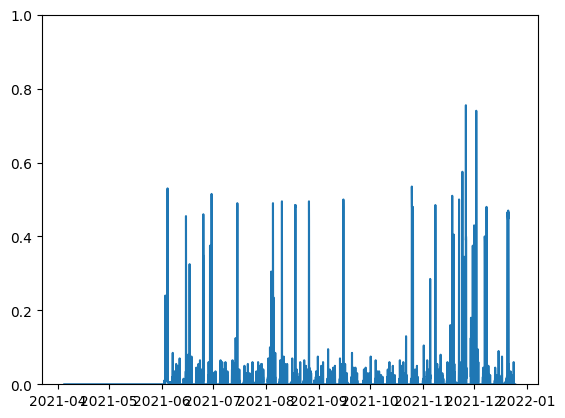

In [51]:
time_data = df_water_meters_data['sensor_data'][0]['timestamps']
sensor_value_data = df_water_meters_data['sensor_data'][0]['values']
plt.plot(time_data, sensor_value_data)
plt.ylim(0, 1)

### Outside air temp sensor (weather station)

In [52]:
filename_ttl='datasets/bts_site_b_train/Site_B.ttl'
g = Graph().parse(filename_ttl)
# Define the SPARQL query to retrieve Outside_Air_Temperature_Sensor
query_outside_airtemp = """
SELECT ?sensor ?stream_id 
WHERE {
    ?sensor rdf:type brick:Outside_Air_Temperature_Sensor .
    ?sensor brick:isPointOf   ?loc .
    ?loc a brick:Weather_Station .
    ?sensor senaps:stream_id ?stream_id .
}
ORDER BY ?stream_id
"""
# Run the query
results_outside_airtemp = g.query(query_outside_airtemp)
# Prepare the data for the DataFrame
data_outside_airtemp = []
for row in results_outside_airtemp:
    data_outside_airtemp.append({
        'Sensor': str(row['sensor']),
        'Stream ID': str(row['stream_id']),
    })
# Create a DataFrame from the results
df_outside_airtemp = pd.DataFrame(data_outside_airtemp)
# Display the DataFrame
display(df_outside_airtemp.head())

,Sensor,Stream ID
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,664ddc27_ccc5_43a1_97b7_3000c0e948db


In [53]:
df_outside_air_temp_data = load_sensors_from_db(df_outside_airtemp, db)
df_outside_air_temp_data

,Sensor,Stream ID,sensor_data
0,dch:org/df125f8d_93e4_4a4f_bc87_1c4e332f32b8/s...,664ddc27_ccc5_43a1_97b7_3000c0e948db,{'streamid': '664ddc27_ccc5_43a1_97b7_3000c0e9...


In [54]:
df_outside_temperature = pd.DataFrame(df_outside_air_temp_data['sensor_data'][0])

In [55]:
df_outside_temperature.head()

,streamid,sensor_type,timestamps,values
0,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:03:11.512,26.250
1,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:13:40.218,26.765
2,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:23:11.538,27.585
3,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:33:11.510,28.300
4,664ddc27_ccc5_43a1_97b7_3000c0e948db,Outside_Air_Temperature_Sensor,2021-01-01 00:43:11.600,28.820


#### Compute correlation

### Outside temperature

In [56]:
df_outside_temperature['timestamps'] = pd.to_datetime(df_outside_temperature['timestamps'])
daily_median_outside_temperature = df_outside_temperature.groupby(df_outside_temperature['timestamps'].dt.date)['values'].median().reset_index()
daily_median_outside_temperature.columns = ['date', 'outside_temp']
daily_median_outside_temperature.head()

,date,outside_temp
0,2021-01-01,24.940
1,2021-01-02,18.630
2,2021-01-03,17.620
3,2021-01-04,16.035
4,2021-01-05,16.505


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Function to compute rolling Spearman's Rank Correlation
def rolling_spearman(x, y, window):
    corr_values = []
    for i in range(len(x) - window + 1):
        # Compute Spearman's Rank Correlation for each rolling window
        corr, _ = spearmanr(x[i:i + window], y[i:i + window])
        # print(corr)
        corr_values.append(corr)
    # Pad with NaNs at the start to match the length of original data
    return np.concatenate((np.full(window - 1, np.nan), corr_values))

### Water sensor data 

In [71]:
df_water_sensor_data_1 = water_sensor_data[1]
df_water_sensor_data_1['timestamps'] = pd.to_datetime(df_water_sensor_data_1['timestamps'])
daily_median_water_sensor_data_1 = df_water_sensor_data_1.groupby(df_water_sensor_data_1['timestamps'].dt.date)['values'].median().reset_index()
daily_median_water_sensor_data_1.columns = ['date', 'water_sensor_val']
daily_median_water_sensor_data_1.head()

,date,water_sensor_val
0,2021-04-05,5.875
1,2021-04-06,5.875
2,2021-04-07,5.875
3,2021-04-08,5.875
4,2021-04-09,5.875


In [72]:
daily_median_water_sensor_data = []
for i in range(len(water_sensor_data)):
    df_water_sensor_data_1 = water_sensor_data[i]
    df_water_sensor_data_1['timestamps'] = pd.to_datetime(df_water_sensor_data_1['timestamps'])
    daily_median_water_sensor_data_1 = df_water_sensor_data_1.groupby(df_water_sensor_data_1['timestamps'].dt.date)['values'].median().reset_index()
    daily_median_water_sensor_data_1.columns = ['date', 'water_sensor_val']
    daily_median_water_sensor_data.append(daily_median_water_sensor_data_1)
    

In [73]:
df_water_temperature = daily_median_water_sensor_data[0].copy()
df_water_temperature.columns = ['date', 'sensor1']
# Loop through the remaining dataframes and merge them
for i, df in enumerate(daily_median_water_sensor_data[1:], start=2):
    df.columns = ['date', f'sensor{i}']
    df_water_temperature = pd.merge(df_water_temperature, df, on='date', how='outer')

In [74]:
df_water_temperature

,date,sensor1,sensor2
0,2021-04-04,0.0000,NaN
1,2021-04-05,0.0000,5.875
2,2021-04-06,0.0000,5.875
3,2021-04-07,0.0000,5.875
4,2021-04-08,0.0000,5.875
...,...,...,...
252,2021-12-20,0.4525,72.830
253,2021-12-21,0.0025,79.170
254,2021-12-22,0.0000,79.255
255,2021-12-23,0.0000,79.300


In [75]:
df_water_outside_temperature = df_water_temperature.merge(daily_median_outside_temperature, on='date', how='inner')
df_water_outside_temperature['date'] = pd.to_datetime(df_water_outside_temperature['date'])

In [76]:
df_water_outside_temperature.dtypes

date            datetime64[ns]
sensor1                float64
sensor2                float64
outside_temp           float64
dtype: object

In [77]:
# df_water_outside_temperature = df_water_outside_temperature.dropna()

In [78]:
df_water_outside_temperature.head()


,date,sensor1,sensor2,outside_temp
0,2021-04-04,0.0,NaN,16.9150
1,2021-04-05,0.0,5.875,14.6100
2,2021-04-06,0.0,5.875,16.8800
3,2021-04-07,0.0,5.875,18.2450
4,2021-04-08,0.0,5.875,20.3925


In [79]:
# df = None

/tmp/ipykernel_35801/3377352297.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]


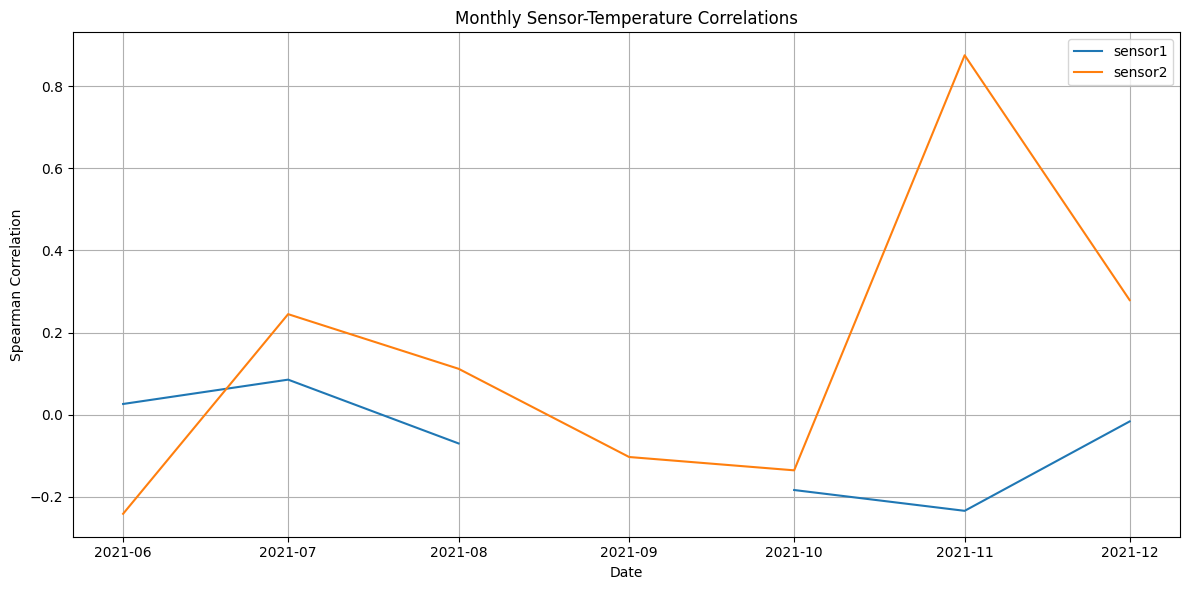

In [80]:
# Create the year_month column
df_water_outside_temperature['year_month'] = df_water_outside_temperature['date'].dt.to_period('M')

def calculate_monthly_correlation(dataframe, sensor_column):
    return dataframe.groupby('year_month').apply(
        lambda x: stats.spearmanr(x["outside_temp"], x[sensor_column])[0]
    )

sensor_columns = ['sensor1', 'sensor2']

# Dictionary to store results
monthly_correlations = {}

for sensor in sensor_columns:
    # Skip sensors with all NaN values
    if df_water_outside_temperature[sensor].isna().all():
        # print(f"Skipping {sensor} as it contains all NaN values.")
        continue
    
    monthly_correlations[sensor] = calculate_monthly_correlation(df_water_outside_temperature, sensor)

# Convert results to a dataframe
result_df = pd.DataFrame(monthly_correlations)

# Reset the index to make year_month a column
result_df = result_df.reset_index()
result_df['date'] = result_df['year_month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
for sensor in sensor_columns:
    if sensor in result_df.columns:
        plt.plot(result_df['date'], result_df[sensor], label=sensor)

plt.title('Monthly Water Sensor-Temperature Correlations')
plt.xlabel('Date')
plt.ylabel('Spearman Correlation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
result_df = result_df.fillna(0)  ## Missing is set to 0

In [82]:
result_df

,year_month,sensor1,sensor2,date
0,2021-04,0.000000,0.000000,2021-04-01
1,2021-05,0.000000,0.000000,2021-05-01
2,2021-06,0.025871,-0.241702,2021-06-01
3,2021-07,0.085145,0.244700,2021-07-01
4,2021-08,-0.070330,0.111571,2021-08-01
5,2021-09,0.000000,-0.103345,2021-09-01
6,2021-10,-0.183786,-0.135813,2021-10-01
7,2021-11,-0.234479,0.875484,2021-11-01
8,2021-12,-0.016644,0.278868,2021-12-01


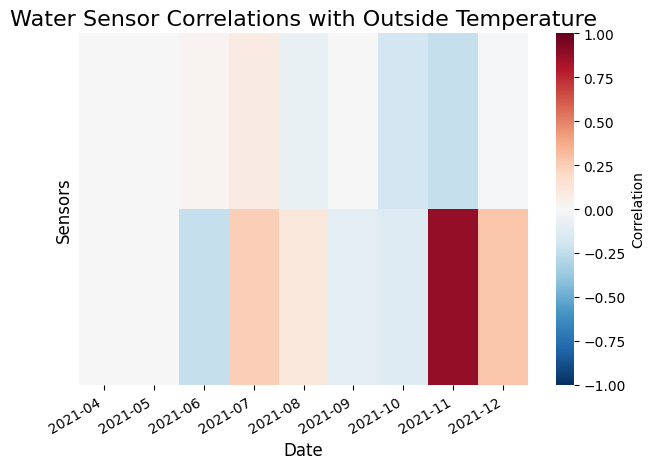

In [84]:
# Create the heatmap
sns.heatmap(result_df[['sensor1', 'sensor2']].T, 
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlation'},
            xticklabels=result_df['date'].dt.strftime('%Y-%m'),
            # yticklabels=['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6']
            yticklabels=[]
            )

# Customize the plot
plt.title('Water Sensor Correlations with Outside Temperature', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sensors', fontsize=12)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Use tight layout to ensure all elements fit in the figure
plt.tight_layout()

In [85]:
df = result_df

In [86]:
result_df

,year_month,sensor1,sensor2,date
0,2021-04,0.000000,0.000000,2021-04-01
1,2021-05,0.000000,0.000000,2021-05-01
2,2021-06,0.025871,-0.241702,2021-06-01
3,2021-07,0.085145,0.244700,2021-07-01
4,2021-08,-0.070330,0.111571,2021-08-01
5,2021-09,0.000000,-0.103345,2021-09-01
6,2021-10,-0.183786,-0.135813,2021-10-01
7,2021-11,-0.234479,0.875484,2021-11-01
8,2021-12,-0.016644,0.278868,2021-12-01


In [87]:
# WaterAnalysis_WeatherSensitivity

In [88]:
df.to_csv('WaterAnalysis_WeatherSensitivity.csv', index=True)